In [2]:
#from utils import *

import time
import numpy as np
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [5]:
def parser(x):
    """
    Converts Google Finance Datetime format into YYYY-MM-DD
    """
    ts = datetime.datetime.strptime(x,'%m/%d/%Y %H:%M:%S')
    return datetime.datetime.strftime(ts, '%Y-%m-%d')

In [6]:
fin50_df = pd.read_csv('data/finance50.csv', header=0, parse_dates=[0])
indices_df = pd.read_csv('data/indices.csv', header=0, parse_dates=[0])
forex_df = pd.read_csv('data/forex.csv', header=0, parse_dates=[0])

In [7]:
gs_df = pd.read_csv('data/GS.csv', header=0, parse_dates=[-1])

In [8]:
gs_df.head()

,open,close,adj_close,low,high,volume,date
0,84.019997,86.760002,76.698608,82.190002,87.620003,14088500,2009-01-02
1,85.809998,88.779999,78.484337,85.459999,90.949997,15996700,2009-01-05
2,90.050003,88.709999,78.422478,87.720001,92.199997,21551800,2009-01-06
3,86.910004,84.500000,74.700706,83.650002,87.849998,12465500,2009-01-07
4,83.519997,85.410004,75.505180,82.680000,86.519997,13448100,2009-01-08


## Train/Test Split

In [9]:
0.7*len(gs_df)

1585.5

In [10]:
gs_df.iloc[1585]

open                      197.91
close                     198.32
adj_close                189.736
low                       196.57
high                      199.16
volume                   1938100
date         2015-04-22 00:00:00
Name: 1585, dtype: object

In [11]:
train_test_split_date = datetime.date(2015, 4, 22)

## Preliminary plots of Closing Prices

In [12]:
def plot_stock_prices(in_df, var, stock_name):
    plt.figure(figsize=(14, 5), dpi=100)
    label_str = stock_name + ' stock'
    title_str = stock_name + ' stock price (' + var + ')'
    plt.plot(in_df['date'], in_df[var], label=label_str)
    plt.vlines(train_test_split_date, 0, 1.05*max(in_df[var]), linestyles='--', colors='gray', label='Train/Test data cut-off')
    plt.xlabel('date')
    plt.ylabel('USD')
    plt.title(title_str)
    plt.legend()
    plt.show()

/opt/tljh/user/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


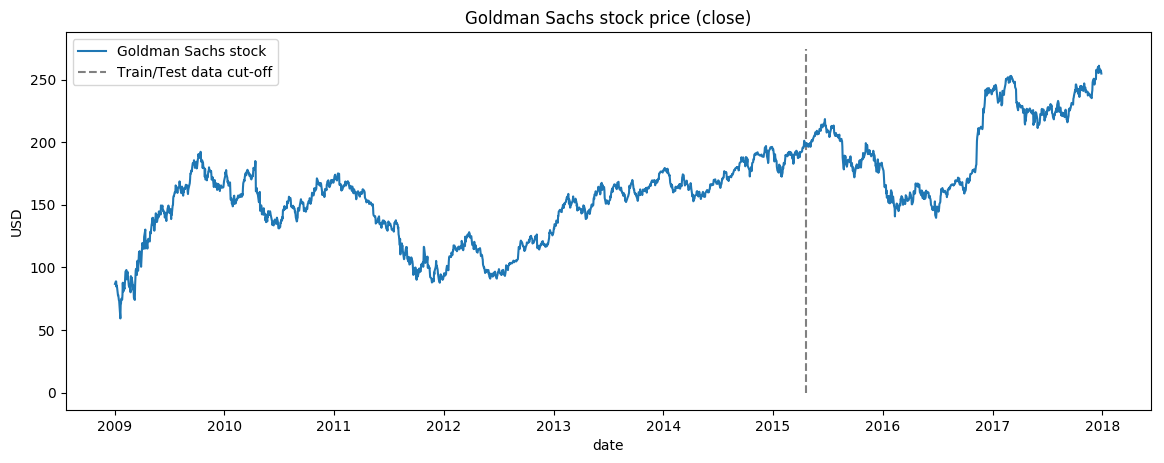

In [13]:
plot_stock_prices(gs_df, 'close', 'Goldman Sachs')

## Technical Indicators

In [14]:
def get_technical_indicators(in_df, var):
    # Create 7 and 21 days Moving Average
    in_df['ma7'] = in_df[var].rolling(window=7).mean()
    in_df['ma14'] = in_df[var].rolling(window=14).mean()
    in_df['ma21'] = in_df[var].rolling(window=21).mean()
    in_df['ma28'] = in_df[var].rolling(window=28).mean()
    
    # Create MACD
    in_df['26ema'] = pd.Series.ewm(in_df[var], span=26, adjust=False).mean()
    in_df['12ema'] = pd.Series.ewm(in_df[var], span=12, adjust=False).mean()
    in_df['MACD'] = (in_df['12ema']-in_df['26ema'])

    # Create Bollinger Bands
    in_df['20sd'] = in_df[var].rolling(20).std()
    in_df['upper_band'] = in_df['ma21'] + (in_df['20sd']*2)
    in_df['lower_band'] = in_df['ma21'] - (in_df['20sd']*2)
    
    # Create Exponential moving average
    in_df['ema'] = in_df[var].ewm(com=0.5).mean()
    
    # Create Momentum
    in_df['log_return'] = np.log(in_df[var]/in_df[var].shift(1)) 
    
    return in_df

In [15]:
gs_TI_df = get_technical_indicators(gs_df, 'close')

In [16]:
gs_TI_df.head()

,open,close,adj_close,low,high,volume,date,ma7,ma14,ma21,ma28,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,log_return
0,84.019997,86.760002,76.698608,82.190002,87.620003,14088500,2009-01-02,NaN,NaN,NaN,NaN,86.760002,86.760002,0.000000,NaN,NaN,NaN,86.760002,NaN
1,85.809998,88.779999,78.484337,85.459999,90.949997,15996700,2009-01-05,NaN,NaN,NaN,NaN,86.909632,87.070771,0.161139,NaN,NaN,NaN,88.275000,0.023016
2,90.050003,88.709999,78.422478,87.720001,92.199997,21551800,2009-01-06,NaN,NaN,NaN,NaN,87.042992,87.322960,0.279968,NaN,NaN,NaN,88.576153,-0.000789
3,86.910004,84.500000,74.700706,83.650002,87.849998,12465500,2009-01-07,NaN,NaN,NaN,NaN,86.854622,86.888658,0.034036,NaN,NaN,NaN,85.824750,-0.048621
4,83.519997,85.410004,75.505180,82.680000,86.519997,13448100,2009-01-08,NaN,NaN,NaN,NaN,86.747614,86.661173,-0.086441,NaN,NaN,NaN,85.547110,0.010712


In [17]:
## Plot Technical Indicators

In [18]:
def plot_technical_indicators(dataset, var, last_days, label):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(3, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset[var],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for ' + label + ' - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(3, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_return'],label='Log Return', color='b',linestyle='-')

    # Plot third subplot
    plt.subplot(3, 1, 3)
    plt.title('Log Return')
    plt.plot(dataset['log_return'],label='Log Return', color='b',linestyle='-')
    
    plt.legend()
    plt.show()

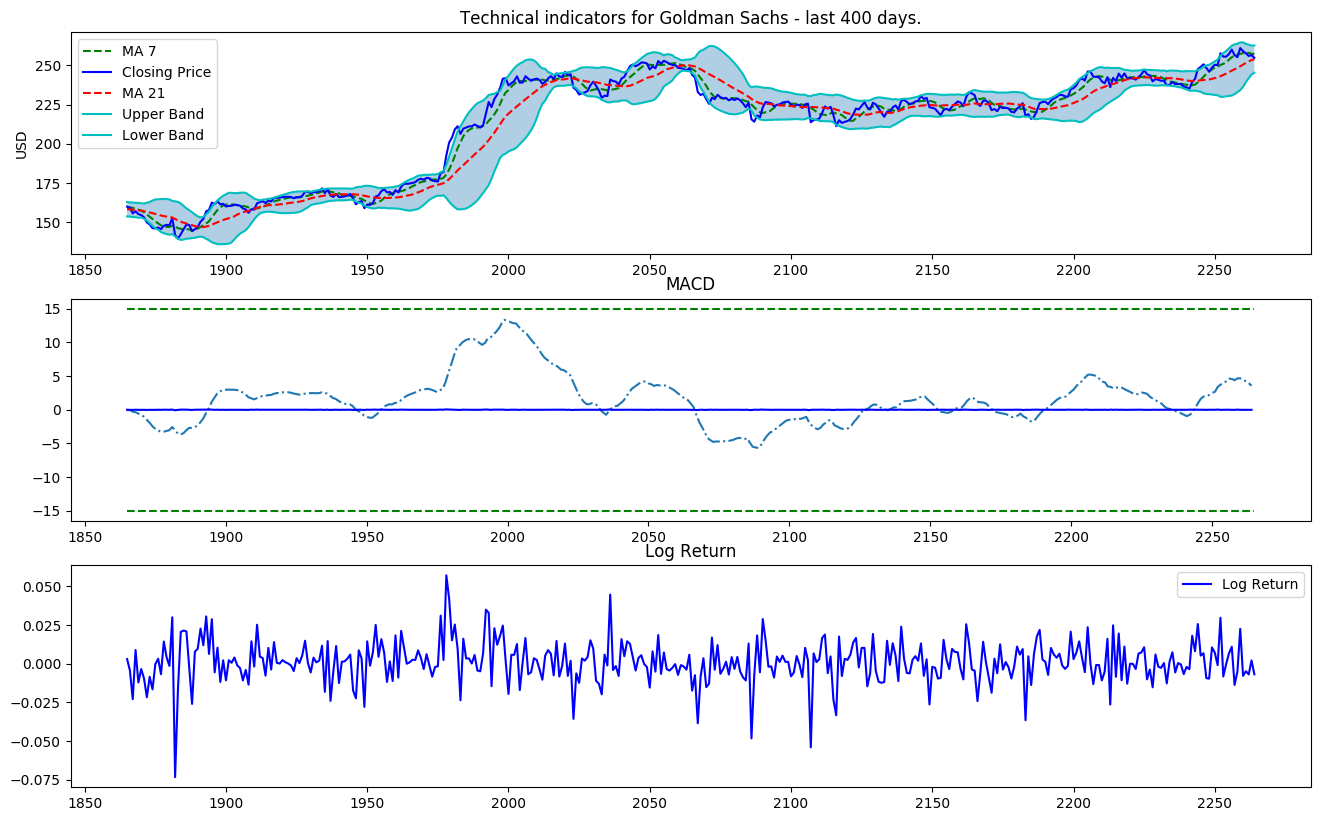

In [19]:
plot_technical_indicators(gs_TI_df, 'close', 400, 'Goldman Sachs')

## Fourier Transforms

In [20]:
def calc_fft_feat(in_df, var):
    close_fft = np.fft.fft(np.asarray(in_df[var].tolist()))
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    
    return fft_df

In [21]:
def plot_fft(in_df, fft_df, var, label):
    plt.figure(figsize=(14, 7), dpi=100)
    fft_list = np.asarray(fft_df['fft'].tolist())
    for num_ in [3, 6, 9, 100]:
        fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
        plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
    plt.plot(in_df[var],  label='Real')
    plt.xlabel('Days')
    plt.ylabel('USD')
    plt.title(label + ' (' + var + ') stock prices & Fourier transforms')
    plt.legend()
    plt.show()

In [22]:
gs_FT_df = calc_fft_feat(gs_df, 'close')

In [23]:
gs_FT_df.head()

,fft,absolute,angle
0,(368270.77002334595+0j),368270.770023,0.000000
1,(22195.865621058354+34346.29761974874j),40894.065717,0.997071
2,(4497.7915124366655-8131.844240238557j),9292.847746,-1.065570
3,(-2943.2554079246856+17900.861043552173j),18141.212156,1.733758
4,(3545.323649033141+21247.820603040305j),21541.569120,1.405464


In [24]:
fft_list = np.asarray(gs_FT_df['fft'].tolist())

In [25]:
fft_list

array([368270.77002335    +0.j        ,  22195.86562106+34346.29761975j,
         4497.79151244 -8131.84424024j, ...,
        -2943.25540792-17900.86104355j,   4497.79151244 +8131.84424024j,
        22195.86562106-34346.29761975j])

In [26]:
len(fft_list)

2265

/opt/tljh/user/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


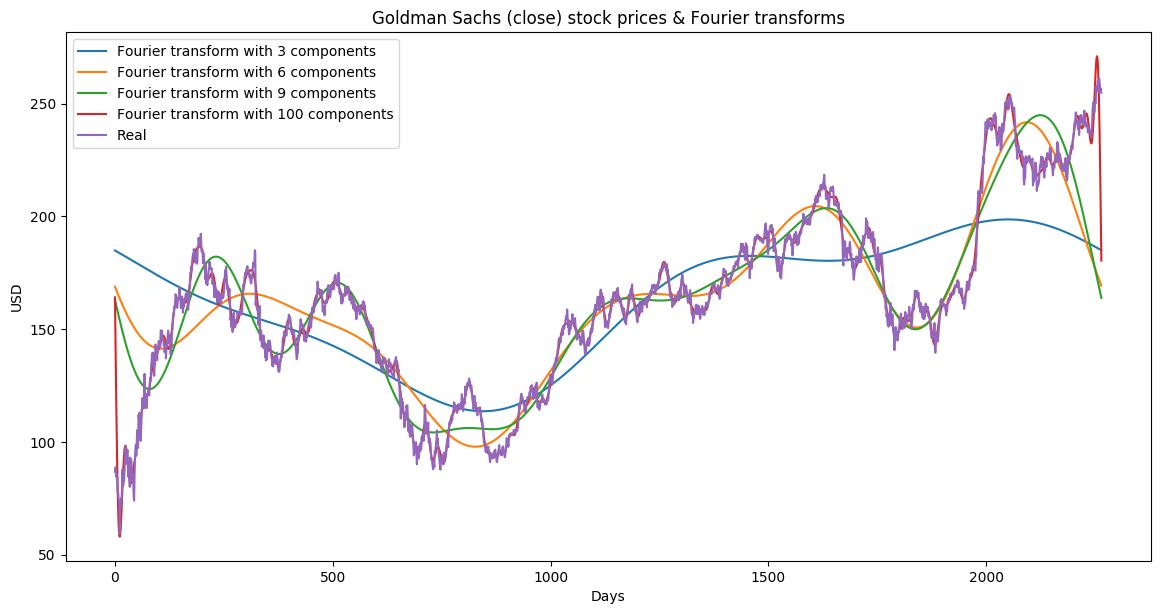

In [27]:
plot_fft(gs_df, gs_FT_df, 'close', 'Goldman Sachs')

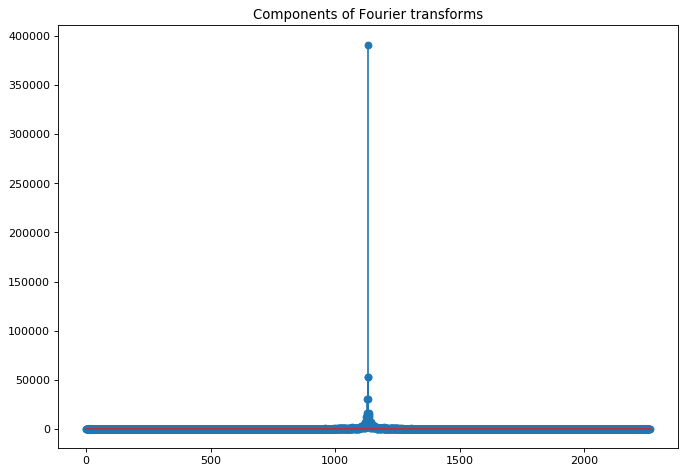

In [77]:
from collections import deque
items = deque(np.asarray(gs_FT_df['absolute'].tolist()))
items.rotate(int(np.floor(len(gs_FT_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Components of Fourier transforms')
plt.show()

## ARIMA

In [28]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = gs_df['close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 2264
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5498.094
Method:                       css-mle   S.D. of innovations              2.744
Date:                Sun, 14 Apr 2019   AIC                          11010.188
Time:                        16:09:15   BIC                          11050.263
Sample:                             1   HQIC                         11024.811
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0743      0.053      1.405      0.160      -0.029       0.178
ar.L1.D.close    -0.0716      0.021     -3.409      0.001      -0.113      -0.030
ar.L2.D.close     0.0117      0.021     

In [44]:
model_fit

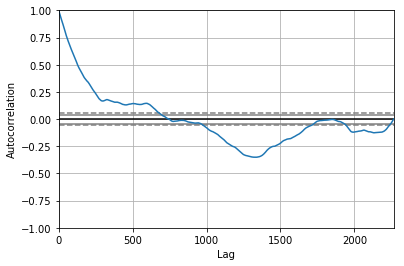

<Figure size 800x560 with 0 Axes>

In [29]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [30]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [31]:
len(history)

2265

In [32]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2263
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5495.994
Method:                       css-mle   S.D. of innovations              2.745
Date:                Sun, 14 Apr 2019   AIC                          11005.989
Time:                        16:11:15   BIC                          11046.060
Sample:                             1   HQIC                         11020.610
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0750      0.053      1.417      0.157      -0.029       0.179
ar.L1.D.y     -0.0716      0.021     -3.408      0.001      -0.113      -0.030
ar.L2.D.y      0.0115      0.021      0.546      0.5

In [49]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 7.840


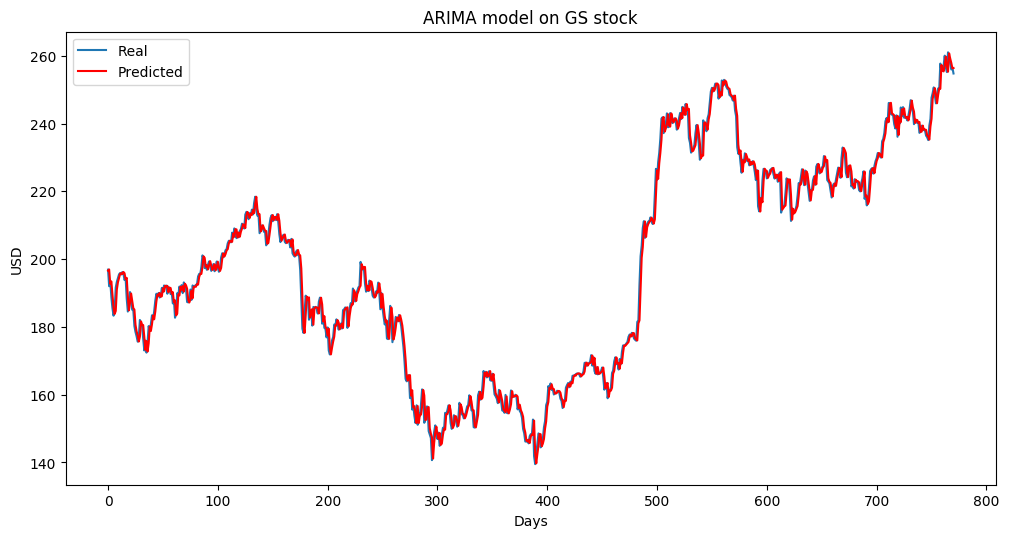

In [33]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('ARIMA model on GS stock')
plt.legend()
plt.show()

## Combining Features

Closing Price

Open, High, Low, Volume - 4 Features

Technical Indicator Features:
* 7, 14, 21, 28 Day MA
* 12, 26 Day EMA
* MACD
* Bollinger Bands (Upper and Lower)
* EMA
* Momentum
Total = 11 Features

FFT Features:
* 3, 6, 9, 15 Components Prediction
Total = 4 Features

ARIMA Features:
* ARIMA(5,1,0) Prediction


In [34]:
def fft_pred(in_df, fft_df):
    out_df = in_df
    fft_list = np.asarray(fft_df['fft'].tolist())
    for num_ in [3, 6, 9, 15]:
        fft_list_m10 = np.copy(fft_list)
        fft_list_m10[num_:-num_]=0
        var_str = 'fft' + str(num_)
        out_df[var_str] = np.real(np.fft.ifft(fft_list_m10))
    return out_df

In [35]:
def arima_pred(in_df, var):
    series = in_df[var]
    X = series.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    out_df = in_df
    out_df['arima'] = history
    
    return out_df
    

In [36]:
gs_TI_df = get_technical_indicators(gs_df, 'close')
gs_fft_df = calc_fft_feat(gs_df, 'close')
gs_FT_df = fft_pred(gs_df, gs_fft_df)
gs_arima_df = arima_pred(gs_df, 'close')

/opt/tljh/user/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [37]:
gs_FT_df = fft_pred(gs_df, gs_fft_df)

In [38]:
gs_df.tail() # Note: Already has all the feaures because we didn't make a new copy of the original dataframe

,open,close,adj_close,low,high,volume,date,ma7,ma14,ma21,...,20sd,upper_band,lower_band,ema,log_return,fft3,fft6,fft9,fft15,arima
2260,261.660004,258.970001,257.335083,257.720001,262.140015,2100600,2017-12-22,257.758573,254.347858,250.473333,...,7.072825,264.618984,236.327683,259.079997,-0.007847,185.411011,171.373914,167.351533,174.659151,258.970001
2261,258.190002,257.720001,256.092987,256.000000,259.200012,1289300,2017-12-26,258.078574,255.018572,251.510000,...,6.106755,263.723510,239.296491,258.173333,-0.004839,185.301810,170.855671,166.469079,172.598490,257.720001
2262,257.980011,255.949997,254.334152,255.520004,257.980011,1567900,2017-12-27,257.904286,255.732858,252.502381,...,5.336351,263.175082,241.829680,256.691109,-0.006892,185.192411,170.340585,165.590002,170.536154,255.949997
2263,256.980011,256.500000,254.880676,255.100006,257.000000,1301000,2017-12-28,257.401430,256.300001,253.316190,...,4.597491,262.511173,244.121208,256.563703,0.002147,185.082817,169.828718,164.714530,168.473727,256.500000
2264,255.869995,254.759995,253.151657,252.910004,256.649994,2519300,2017-12-29,257.155714,256.615000,253.954285,...,4.355393,262.665071,245.243500,255.361231,-0.006807,184.973031,169.320131,163.842890,166.412794,254.759995


In [39]:
fin50_df.head()

,date,GS,C,BAC,JPM,AXP,USB,CB,CME,SPGI,...,AJG,HBAN,PFG,L,CINF,LNC,SIVB,CMA,RJF,NDAQ
0,2009-01-02,86.760002,71.400002,14.33,31.350000,19.330000,25.250000,53.029999,42.515999,24.610001,...,25.780001,7.98,23.60,29.770000,28.969999,19.950001,25.719999,20.950001,18.010000,26.129999
1,2009-01-05,88.779999,70.800003,13.98,29.250000,19.950001,24.010000,52.660000,42.068001,24.590000,...,25.620001,7.79,23.08,29.809999,28.709999,21.809999,25.290001,19.420000,17.910000,26.740000
2,2009-01-06,88.709999,74.599998,14.28,29.879999,21.070000,23.750000,51.349998,40.599998,25.490000,...,25.750000,7.70,24.48,29.920000,28.920000,25.010000,26.129999,20.370001,19.190001,25.820000
3,2009-01-07,84.500000,71.500000,13.71,28.090000,20.010000,23.370001,49.250000,39.737999,24.719999,...,25.540001,7.15,21.83,28.200001,28.379999,21.219999,25.440001,18.860001,18.400000,24.230000
4,2009-01-08,85.410004,71.599998,13.54,27.219999,20.040001,23.160000,49.500000,38.444000,23.650000,...,25.799999,7.02,21.90,28.469999,29.090000,20.080000,26.120001,18.879999,18.570000,22.440001


In [40]:
fin50_df.drop('GS',axis=1,inplace=True)

In [41]:
fin50_df['date']

0      2009-01-02
1      2009-01-05
2      2009-01-06
3      2009-01-07
4      2009-01-08
5      2009-01-09
6      2009-01-12
7      2009-01-13
8      2009-01-14
9      2009-01-15
10     2009-01-16
11     2009-01-20
12     2009-01-21
13     2009-01-22
14     2009-01-23
15     2009-01-26
16     2009-01-27
17     2009-01-28
18     2009-01-29
19     2009-01-30
20     2009-02-02
21     2009-02-03
22     2009-02-04
23     2009-02-05
24     2009-02-06
25     2009-02-09
26     2009-02-10
27     2009-02-11
28     2009-02-12
29     2009-02-13
          ...    
2235   2017-11-16
2236   2017-11-17
2237   2017-11-20
2238   2017-11-21
2239   2017-11-22
2240   2017-11-24
2241   2017-11-27
2242   2017-11-28
2243   2017-11-29
2244   2017-11-30
2245   2017-12-01
2246   2017-12-04
2247   2017-12-05
2248   2017-12-06
2249   2017-12-07
2250   2017-12-08
2251   2017-12-11
2252   2017-12-12
2253   2017-12-13
2254   2017-12-14
2255   2017-12-15
2256   2017-12-18
2257   2017-12-19
2258   2017-12-20
2259   201

In [42]:
feats_df = gs_df.merge(fin50_df,on='date')

In [43]:
feats_df = feats_df.merge(indices_df, on='date')

In [44]:
feats_df = feats_df.merge(forex_df, on='date')

In [45]:
feats_df.iloc[0]

open                        84.02
close                       86.76
adj_close                 76.6986
low                         82.19
high                        87.62
volume                   14088500
date          2009-01-02 00:00:00
ma7                           NaN
ma14                          NaN
ma21                          NaN
ma28                          NaN
26ema                       86.76
12ema                       86.76
MACD                            0
20sd                          NaN
upper_band                    NaN
lower_band                    NaN
ema                         86.76
log_return                    NaN
fft3                      184.863
fft6                      168.815
fft9                      162.975
fft15                     164.355
arima                       86.76
C                            71.4
BAC                         14.33
JPM                         31.35
AXP                         19.33
USB                         25.25
CB            

In [46]:
feats_df.drop('26ema',axis=1,inplace=True)
feats_df.drop('12ema',axis=1,inplace=True)
feats_df.drop('20sd',axis=1,inplace=True)

In [47]:
feats_df.drop('open',axis=1,inplace=True)
feats_df.drop('adj_close',axis=1,inplace=True)
feats_df.drop('low',axis=1,inplace=True)
feats_df.drop('high',axis=1,inplace=True)
feats_df.drop('volume',axis=1,inplace=True)

In [48]:
print('Total dataset has {} samples, and {} features.'.format(feats_df.shape[0], \
                                                              feats_df.shape[1]))

Total dataset has 2264 samples, and 77 features.


In [51]:
feats_df.to_csv('data/features.csv',header=True,index=False)

## Feature Importance

In [58]:
def get_feature_importance_data(in_df):
    X = in_df.copy()
    X = X[['close', 'ma21', 'MACD', '20sd', 'upper_band', 'lower_band','log_return']]
    y = X['close']
    X.drop('close',axis=1, inplace=True)
    
    train_samples = int(X.shape[0] * 0.66)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [59]:
(X_train, y_train), (X_test, y_test) = get_feature_importance_data(gs_df)

In [65]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=250,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [66]:
xgbModel = regressor.fit(X_train,y_train, \
                         eval_set = [(X_train, y_train), (X_test, y_test)], \
                         verbose=False)

In [67]:
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

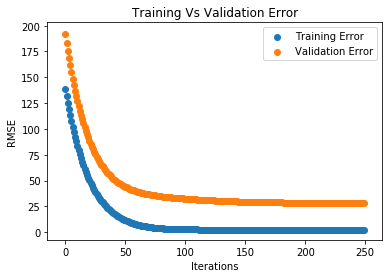

In [68]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

In [72]:
eval_result['validation_1']['rmse']

[191.550781,
 183.481064,
 175.712753,
 168.389694,
 161.652847,
 154.99823,
 148.630325,
 142.858398,
 137.103271,
 131.607666,
 126.615089,
 122.015587,
 117.551926,
 113.416885,
 109.473137,
 105.405968,
 101.871475,
 98.43325,
 95.08976,
 91.729095,
 88.70401,
 85.702766,
 82.898491,
 80.389709,
 77.787849,
 75.527702,
 73.187897,
 71.106415,
 69.167938,
 67.165779,
 65.399712,
 63.776535,
 62.28019,
 60.647072,
 59.103153,
 57.641514,
 56.358521,
 55.043541,
 53.961823,
 52.895126,
 51.803356,
 50.762909,
 49.83984,
 48.992397,
 48.103481,
 47.267941,
 46.550552,
 45.818096,
 45.125626,
 44.49144,
 43.964397,
 43.433937,
 42.823147,
 42.29237,
 41.770409,
 41.332272,
 40.858906,
 40.435432,
 40.009495,
 39.666672,
 39.362011,
 39.040375,
 38.659229,
 38.304665,
 38.060795,
 37.799049,
 37.473694,
 37.266258,
 36.975082,
 36.74855,
 36.551502,
 36.33971,
 36.146076,
 35.932968,
 35.75827,
 35.552238,
 35.39333,
 35.128052,
 34.997597,
 34.747704,
 34.617825,
 34.516037,
 34.329575,

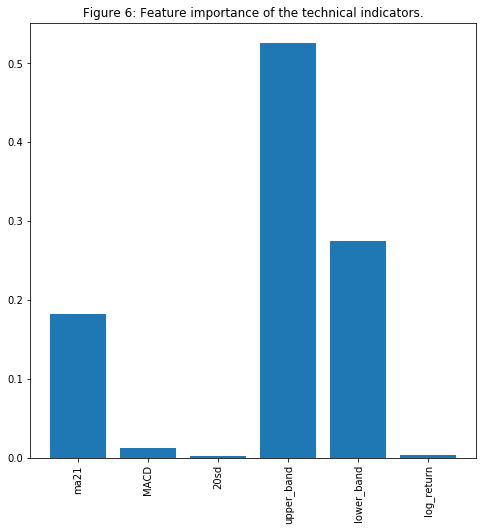

In [69]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show() # This is different from what he got in his notebook?!

## Using PCA instead of XGBoost

In [229]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [256]:
pca = PCA(n_components=.95)

In [257]:
x_pca = StandardScaler().fit_transform(X_train)

In [258]:
principalComponents = pca.fit_transform(x_pca[28:])

In [259]:
principalComponents.shape

(1465, 4)

In [260]:
pca.explained_variance_ratio_

array([0.62987865, 0.15472499, 0.12042832, 0.09448243])

## Autoencoder Features

In [65]:
def get_train_test_split(in_df):
    X = in_df.copy()
    y = X['close']
    X.drop('close',axis=1, inplace=True)
    X.drop('date',axis=1, inplace=True)
    
    train_samples = int(X.shape[0] * 0.7) + 1
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

### Extract train/test and scale

In [66]:
(X_train, y_train), (X_test, y_test) = get_train_test_split(feats_df)

In [106]:
X_train_red = X_train[28:]
y_train_red = y_train[28:]

In [ ]:
X_test['PFG'][2255] = X_test['PFG'][2254]

In [107]:
from sklearn import preprocessing

In [108]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train_red)

In [110]:
X_train_scaled

array([[0.10411146, 0.02518667, 0.        , ..., 0.1545613 , 0.85487977,
        0.04203822],
       [0.11446643, 0.03947174, 0.00884956, ..., 0.19436374, 0.83224894,
        0.06029724],
       [0.10574774, 0.04425483, 0.01391375, ..., 0.15746659, 0.90862801,
        0.0133758 ],
       ...,
       [0.99518884, 0.99039529, 0.99570737, ..., 0.34453806, 0.79066478,
        0.30063694],
       [0.99665416, 0.99609006, 0.99728886, ..., 0.34991284, 0.80735502,
        0.29681529],
       [1.        , 1.        , 1.        , ..., 0.38233585, 0.79179632,
        0.30912951]])

In [112]:
X_test_scaled = min_max_scaler.transform(X_test)

In [62]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

### Train Autoencoder

In [133]:
autoencoder = Sequential()
autoencoder.add(Dense(200, activation='sigmoid', input_dim=75))
autoencoder.add(Dense(128, activation='relu', input_dim=200))
autoencoder.add(Dense(75, activation='relu', input_dim=128))
autoencoder.add(Dense(128, activation='relu', input_dim=75))
autoencoder.add(Dense(200, activation='relu', input_dim=128))
autoencoder.add(Dense(75, activation='sigmoid', input_dim=200))

In [134]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(X_train_scaled, X_train_scaled,
                epochs=400,
                batch_size=256,
                shuffle=False,
                validation_data=(X_test_scaled, X_test_scaled))

Train on 1557 samples, validate on 679 samples
Epoch 1/400
1557/1557 [==============================] - 4s 2ms/sample - loss: 0.0638 - val_loss: 0.3394
Epoch 2/400
1557/1557 [==============================] - 0s 28us/sample - loss: 0.0583 - val_loss: 0.3315
Epoch 3/400
1557/1557 [==============================] - 0s 26us/sample - loss: 0.0562 - val_loss: 0.3240
Epoch 4/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0544 - val_loss: 0.3129
Epoch 5/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0542 - val_loss: 0.3014
Epoch 6/400
1557/1557 [==============================] - 0s 25us/sample - loss: 0.0537 - val_loss: 0.2909
Epoch 7/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0533 - val_loss: 0.2806
Epoch 8/400
1557/1557 [==============================] - 0s 25us/sample - loss: 0.0529 - val_loss: 0.2681
Epoch 9/400
1557/1557 [==============================] - 0s 26us/sample - loss: 0.0527 - val_loss: 0.2556


1557/1557 [==============================] - 0s 26us/sample - loss: 0.0060 - val_loss: 0.0719
Epoch 78/400
1557/1557 [==============================] - 0s 26us/sample - loss: 0.0088 - val_loss: 0.0723
Epoch 79/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0059 - val_loss: 0.0739
Epoch 80/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0071 - val_loss: 0.0732
Epoch 81/400
1557/1557 [==============================] - 0s 26us/sample - loss: 0.0106 - val_loss: 0.0733
Epoch 82/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0120 - val_loss: 0.0730
Epoch 83/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0083 - val_loss: 0.0740
Epoch 84/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0072 - val_loss: 0.0723
Epoch 85/400
1557/1557 [==============================] - 0s 26us/sample - loss: 0.0063 - val_loss: 0.0740
Epoch 86/400
1557/1557 [==========================

1557/1557 [==============================] - 0s 25us/sample - loss: 0.0039 - val_loss: 0.0717
Epoch 154/400
1557/1557 [==============================] - 0s 29us/sample - loss: 0.0032 - val_loss: 0.0721
Epoch 155/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0030 - val_loss: 0.0722
Epoch 156/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0030 - val_loss: 0.0721
Epoch 157/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0030 - val_loss: 0.0722
Epoch 158/400
1557/1557 [==============================] - 0s 28us/sample - loss: 0.0029 - val_loss: 0.0720
Epoch 159/400
1557/1557 [==============================] - 0s 26us/sample - loss: 0.0029 - val_loss: 0.0723
Epoch 160/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0029 - val_loss: 0.0718
Epoch 161/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0030 - val_loss: 0.0724
Epoch 162/400
1557/1557 [=================

Epoch 229/400
1557/1557 [==============================] - 0s 26us/sample - loss: 0.0026 - val_loss: 0.0726
Epoch 230/400
1557/1557 [==============================] - 0s 26us/sample - loss: 0.0026 - val_loss: 0.0726
Epoch 231/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0025 - val_loss: 0.0726
Epoch 232/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0025 - val_loss: 0.0726
Epoch 233/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0025 - val_loss: 0.0725
Epoch 234/400
1557/1557 [==============================] - 0s 26us/sample - loss: 0.0025 - val_loss: 0.0726
Epoch 235/400
1557/1557 [==============================] - 0s 26us/sample - loss: 0.0024 - val_loss: 0.0725
Epoch 236/400
1557/1557 [==============================] - 0s 25us/sample - loss: 0.0024 - val_loss: 0.0725
Epoch 237/400
1557/1557 [==============================] - 0s 24us/sample - loss: 0.0024 - val_loss: 0.0725
Epoch 238/400
1557/1557 [===

Epoch 305/400
1557/1557 [==============================] - 0s 25us/sample - loss: 0.0027 - val_loss: 0.0724
Epoch 306/400
1557/1557 [==============================] - 0s 25us/sample - loss: 0.0028 - val_loss: 0.0728
Epoch 307/400
1557/1557 [==============================] - 0s 26us/sample - loss: 0.0033 - val_loss: 0.0723
Epoch 308/400
1557/1557 [==============================] - 0s 26us/sample - loss: 0.0035 - val_loss: 0.0729
Epoch 309/400
1557/1557 [==============================] - 0s 26us/sample - loss: 0.0041 - val_loss: 0.0726
Epoch 310/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0040 - val_loss: 0.0733
Epoch 311/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0043 - val_loss: 0.0726
Epoch 312/400
1557/1557 [==============================] - 0s 28us/sample - loss: 0.0034 - val_loss: 0.0739
Epoch 313/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0030 - val_loss: 0.0726
Epoch 314/400
1557/1557 [===

Epoch 381/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0025 - val_loss: 0.0742
Epoch 382/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0025 - val_loss: 0.0726
Epoch 383/400
1557/1557 [==============================] - 0s 25us/sample - loss: 0.0023 - val_loss: 0.0739
Epoch 384/400
1557/1557 [==============================] - 0s 27us/sample - loss: 0.0023 - val_loss: 0.0729
Epoch 385/400
1557/1557 [==============================] - 0s 26us/sample - loss: 0.0022 - val_loss: 0.0737
Epoch 386/400
1557/1557 [==============================] - 0s 25us/sample - loss: 0.0022 - val_loss: 0.0730
Epoch 387/400
1557/1557 [==============================] - 0s 28us/sample - loss: 0.0022 - val_loss: 0.0734
Epoch 388/400
1557/1557 [==============================] - 0s 28us/sample - loss: 0.0022 - val_loss: 0.0730
Epoch 389/400
1557/1557 [==============================] - 0s 28us/sample - loss: 0.0022 - val_loss: 0.0733
Epoch 390/400
1557/1557 [===

### Get middle activations

In [136]:
rep = Sequential()
rep.add(Dense(200, activation='sigmoid', input_dim=75, weights=autoencoder.layers[0].get_weights()))
rep.add(Dense(128, activation='relu', input_dim=200, weights=autoencoder.layers[1].get_weights()))
rep.add(Dense(75, activation='relu', input_dim=128, weights=autoencoder.layers[2].get_weights()))


In [138]:
activations_train = rep.predict(X_train_scaled)
activations_test = rep.predict(X_test_scaled)

## MHGAN Prediction